In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Input, Dense, GaussianNoise, Lambda
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as bkend
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import numpy as np

M = 4 # alfabeto 256 -> k=8
k = int(np.log2(M)) # bits
n_channel = 2 # usos de canal
n_iter = 100000 # número de simulações
EbNodB_train = 5
R = k/n_channel #taxa [bit/uso de canal]

NUM_EPOCHS = 45
BATCH_SIZE = 32

#####################################################################

train_data = np.random.randint(M, size=n_iter)
data = []
for i in train_data:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
train_data = np.array(data)

input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = Lambda(lambda x: np.sqrt(n_channel) * bkend.l2_normalize(x, axis=1))(encoded1) #Normalizacão l2

EbNo_train = 10 ** (EbNodB_train / 10.0)
encoded3 = GaussianNoise(np.sqrt(1 / (2 * R * EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
#adam = Adam(lr=0.01)
autoencoder.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy')

print(autoencoder.summary())

# Treino do Autodecoder
autoencoder.fit(train_data, train_data,
                epochs=NUM_EPOCHS,
                batch_size=BATCH_SIZE,
                verbose = 1)

# Encoder
encoder = Model(input_signal, encoded2)

# Decoder
encoded_input = Input(shape=(n_channel,))
deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

W0913 18:55:28.103331 11676 deprecation_wrapper.py:119] From c:\users\samuel\anaconda3\envs\autoencoder\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 18:55:28.117325 11676 deprecation_wrapper.py:119] From c:\users\samuel\anaconda3\envs\autoencoder\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 18:55:28.119324 11676 deprecation_wrapper.py:119] From c:\users\samuel\anaconda3\envs\autoencoder\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 18:55:28.162305 11676 deprecation_wrapper.py:119] From c:\users\samuel\anaconda3\envs\autoencoder\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehold

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20  

In [3]:
from scipy.special import erfc
EbNodB_low = -4; EbNodB_high = 8.5; EbNodB_num = 26
test_label = np.random.randint(M, size=n_iter)
test_data = []
for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)

test_data = np.array(test_data)

EbNodB_range = list(np.linspace(EbNodB_low, EbNodB_high, EbNodB_num))
ber = [None] * len(EbNodB_range)
ber_sim = [None] * len(EbNodB_range)
for n in range(0, len(EbNodB_range)):
    EbNo = 10 ** (EbNodB_range[n] / 10.0)
    noise_std = np.sqrt(1 / (2 * R * EbNo))
    noise_mean = 0
    no_errors = 0
    nn = n_iter
    noise = noise_std * np.random.randn(nn, n_channel)
    encoded_signal = encoder.predict(test_data)              
    final_signal = encoded_signal + noise
    pred_final_signal = decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal, axis=1)
    no_errors = (pred_output != test_label)
    no_errors = no_errors.astype(int).sum()
    ber[n] = no_errors / nn
    ber_sim[n] = 0.5*erfc(np.sqrt(EbNo))                         
    print('SNR:', EbNodB_range[n], 'BER:', ber[n])

SNR: -4.0 BER: 0.33824
SNR: -3.5 BER: 0.31404
SNR: -3.0 BER: 0.2929
SNR: -2.5 BER: 0.26802
SNR: -2.0 BER: 0.2465
SNR: -1.5 BER: 0.22241
SNR: -1.0 BER: 0.2012
SNR: -0.5 BER: 0.17785
SNR: 0.0 BER: 0.15272
SNR: 0.5 BER: 0.13159
SNR: 1.0 BER: 0.11234
SNR: 1.5 BER: 0.09221
SNR: 2.0 BER: 0.07557
SNR: 2.5 BER: 0.06126
SNR: 3.0 BER: 0.04705
SNR: 3.5 BER: 0.03683
SNR: 4.0 BER: 0.02692
SNR: 4.5 BER: 0.01947
SNR: 5.0 BER: 0.01291
SNR: 5.5 BER: 0.00913
SNR: 6.0 BER: 0.00538
SNR: 6.5 BER: 0.00316
SNR: 7.0 BER: 0.00184
SNR: 7.5 BER: 0.00125
SNR: 8.0 BER: 0.00051
SNR: 8.5 BER: 0.00024


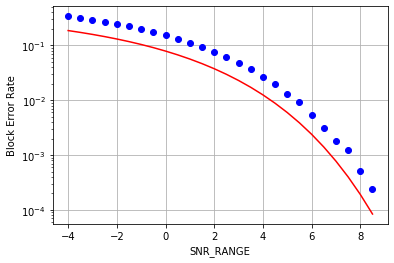

In [4]:
EbNodB_range = list(np.linspace(-4, 8.5, 26))
plt.plot(EbNodB_range, ber,'bo')
plt.plot(EbNodB_range, ber_sim, '-r')
plt.yscale('log')
plt.xlabel('SNR_RANGE')
plt.ylabel('Block Error Rate')
plt.grid()
plt.show()